<td>
   <a target="_blank" href="https://labelbox.com" ><img src="https://labelbox.com/blog/content/images/2021/02/logo-v4.svg" width=256/></a>
</td>

<td>
<a href="https://colab.research.google.com/github/Labelbox/labelbox-python/blob/develop/examples/basics/data_row_metadata.ipynb" target="_blank"><img
src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"></a>
</td>

<td>
<a href="https://github.com/Labelbox/labelbox-python/tree/develop/examples/basics/data_row_metadata.ipynb" target="_blank"><img
src="https://img.shields.io/badge/GitHub-100000?logo=github&logoColor=white" alt="GitHub"></a>
</td>

# Data Row Metadata

Metadata is useful to better understand data on the platform to help with labeling review, model diagnostics, and data selection. This **should not be confused with attachments**. Attachments provide additional context for labelers but is not searchable within Catalog.

### Installation

In [ ]:
!pip install -q --upgrade tensorflow-hub \
                 scikit-learn \
                 seaborn \
                 "labelbox[data]"

## Setup

In [ ]:
import labelbox
import random
import numpy as np
from labelbox import Client
from labelbox.schema.data_row_metadata import (
    DataRowMetadataField,
    DataRowMetadata,
    DeleteDataRowMetadata,
)
from sklearn.random_projection import GaussianRandomProjection
import tensorflow as tf
import seaborn as sns
import tensorflow_hub as hub
from datetime import datetime
from tqdm.notebook import tqdm
import requests
from pprint import pprint
from uuid import uuid4

# API Key and Client
Provide a valid api key below in order to properly connect to the Labelbox Client.

In [ ]:
# Add your api key
API_KEY = None
client = Client(api_key=API_KEY)

## Metadata ontology

We use a similar system for managing metadata as we do feature schemas. Metadata schemas are strongly typed to ensure we can provide the best experience in the App. Each metadata field can be uniquely accessed by id. Names are unique within the kind of metadata, reserved or custom. A DataRow can have a maximum of 5 metadata fields at a time.

### Metadata kinds

* **Enum**: A classification with options, only one option can be selected at a time
* **DateTime**: A utc ISO datetime 
* **Embedding**: 128 float 32 vector used for similarity
* **String**: A string of less than 500 characters

### Reserved fields

* **tag**: a free text field
* **split**: enum of train-valid-test
* **captureDateTime**: ISO 8601 datetime field. All times must be in UTC
* **embedding**: A 128 length list 32 bit floats used for similarity search. All datarows share the same similarity index.

### Custom fields

You can create your own fields from within the app by navigating to the [metadata schema page](https://app.labelbox.com/schema/metadata)

In [ ]:
mdo = client.get_data_row_metadata_ontology()

In [ ]:
# list all your metadata ontology as a dictionary accessable by id 
metadata_ontologies = mdo.fields_by_id
pprint(metadata_ontologies, indent=2)

In [ ]:
# access by name
split_field = mdo.reserved_by_name["split"]
train_field = mdo.reserved_by_name["split"]["train"]

In [ ]:
tag_field = mdo.reserved_by_name["tag"]

In [ ]:
tag_field

## Construct metadata fields

To construct a metadata field you must provide the Schema Id for the field and the value that will be uploaded. You can either construct a DataRowMetadataField object or specify the Schema Id and value in a dictionary format.





Option 1: Specify metadata with a list of DataRowMetadataField. This is the recommended option since it comes with validation for metadata fields.

In [ ]:
# Construct a metadata field of string kind
tag_metadata_field = DataRowMetadataField(
    name="tag",  # specify the schema name
    value="tag_string", # typed inputs
)

# Construct an metadata field of datetime kind
capture_datetime_field = DataRowMetadataField(
    name="captureDateTime",  # specify the schema id
    value=datetime.utcnow(), # typed inputs
)

# Construct a metadata field of Enums options
split_metadta_field = DataRowMetadataField(
    name="split",  # specify the schema id
    value="train", # typed inputs
)

Option 2: Alternatively, you can specify the metadata fields with dictionary format without declaring the DataRowMetadataField objects.


In [ ]:
# Construct a dictionary of string metadata
tag_metadata_field_dict = {
    "name": "tag",
    "value": "tag_string",
}

# Construct a dictionary of datetime metadata
capture_datetime_field_dict = {
    "name": "captureDateTime",
    "value": datetime.utcnow(),
}

# Construct a dictionary of Enums options metadata
split_metadta_field_dict = {
    "name": "split",
    "value": "train",
}

# Upload Data Rows together with metadata

Note: currently, there is a 30k limit on bulk uploading data rows containing metadata.



In [ ]:
# A simple example of uploading Data Rows with metadta
dataset = client.create_dataset(name="Simple Data Rows import with metadata example")

data_row = {"row_data": "https://storage.googleapis.com/labelbox-sample-datasets/Docs/basic.jpg", "external_id": str(uuid4())}
data_row['metadata_fields'] = [tag_metadata_field, capture_datetime_field,  split_metadta_field] 
# Also works with a list of dictionary as specified in Option 2. Uncomment the line below to try. 
# data_row['metadata_fields'] = [tag_metadata_field_dict, capture_datetime_field_dict, split_metadta_field_dict]

task = dataset.create_data_rows([data_row])
task.wait_till_done()

## Accessing Metadata

You can examine individual Data Row, including its metadata.

In [ ]:
datarow = next(dataset.data_rows())
for metadata_field in datarow.metadata_fields:
  print(metadata_field['name'], ":", metadata_field['value'])

You can bulk export metadata given Data Row Ids

In [ ]:
datarows_metadata = mdo.bulk_export([datarow.uid])
len(datarows_metadata)

# Upload/update metadata to existing Data Rows

Next, the following section will go over how to upload or update metadata to existing data rows. 

It also covers a more complex example of adding custom embeddings metadata for similarity search in Catalog. 

## Setup custom embeddings/similarity of Data Rows

Labelbox uses embeddings to power [Similarity Search](https://docs.labelbox.com/docs/similarity). The quality of embeddings is based on how well a machine learning model overlaps with your task. An off the shelf model will perform much worse then a model you have trained yourself.

Here we use a [TensorfFlow Hub](https://tfhub.dev) model trained on Imagenet to create embeddings and then run a dimensionality reduction step to match the Labelbox requirements. You can create your own embeddings using any model of choice, as long as it is a 12 float 32 vector.

In [ ]:
TFHUB_MODEL = "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b0/feature_vector/2"  #@param {type:"string"}

In [ ]:
def make_file_processor(height, width):

    def decode_image(img):
        # convert the compressed string to a 3D uint8 tensor
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.convert_image_dtype(img, dtype=tf.float32)
        return img

    def process_file(bytez):
        img = decode_image(bytez)
        img = tf.image.resize(img, [height, width])
        return img[tf.newaxis, ...]

    return process_file


INPUT_HEIGHT, INPUT_WIDTH = 224, 224
SIMILARITY_DIMENSION = 128
model = hub.KerasLayer(TFHUB_MODEL)
processor = make_file_processor(INPUT_HEIGHT, INPUT_WIDTH)

### Building up uploads

In [ ]:
# Select a dataset to use, or you can just use the 1-image dataset created above. 
dataset_id = dataset.uid
dataset = client.get_dataset(dataset_id)

In [ ]:
dataset.row_count

In [ ]:
# train-valid-test break down
test = 0.05
valid = 0.05 + test
train = 1 - valid

In [ ]:
uploads = []
embeddings = []

for datarow in tqdm(dataset.export_data_rows(), total=dataset.row_count):

    response = requests.get(datarow.row_data, stream=True)

    # assign datarows a split
    rnd = random.random()
    if rnd < test:
        split = "test"
    elif rnd < valid:
        split = "valid"
    else:
        split = "train"

    embeddings.append(
        list(model(processor(response.content), training=False)[0].numpy()))
    dt = datetime.utcnow()
    message = "my-new-message"

    uploads.append(
        DataRowMetadata(
            data_row_id=datarow.uid,
            fields=[
                DataRowMetadataField(
                    name="captureDateTime",
                    value=dt,
                ),
                DataRowMetadataField(name="split", value=split),
                DataRowMetadataField(name="tag", value=message),
            ]))

### Reduce dimensionality

Labelbox supports dimensions of length 128 so we use a [Gaussian Random Projection](https://scikit-learn.org/stable/modules/random_projection.html#gaussian-random-projection) to project the data from 1024 into a compatible size

In [ ]:
gaussian_projected = GaussianRandomProjection(n_components=2).fit_transform(
    np.vstack(embeddings))

In [ ]:
sns.scatterplot(x=gaussian_projected[:, 0], y=gaussian_projected[:, 1])
sns.despine()

In [ ]:
# project to 128 and add to upload
projected = GaussianRandomProjection(n_components=SIMILARITY_DIMENSION,
                                     random_state=42).fit_transform(
                                         np.vstack(embeddings))
for md, embd in zip(uploads, projected):
    md.fields.append(
        DataRowMetadataField(
            name="embedding",
            value=embd.tolist(),  # convert from numpy to list
        ),)

In [ ]:
mdo.bulk_upsert(uploads)

### Upload

Uploads will overwrite the current value for the feature if it is already present.

### Similarity

To access similarity navigate to the datarow page or within a dataset or catalog and toggle the drop down on the left 

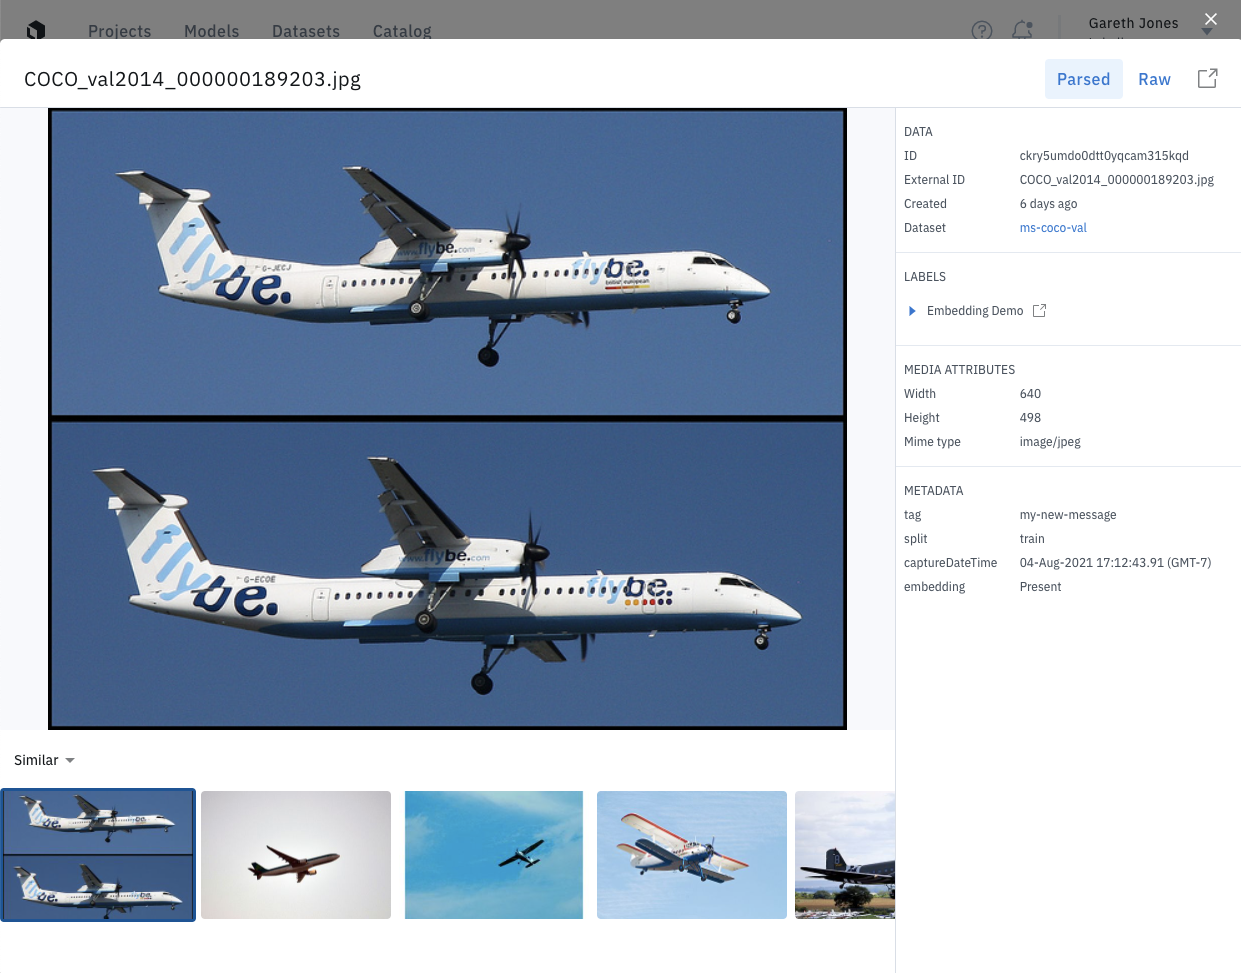



In [ ]:
# datarow page
print(f'https://app.labelbox.com/datarows/{datarow.uid}')

In [ ]:
metadata = mdo.bulk_export([datarow.uid])[0]

## Delete Metadata

To delete fields from a datarow you provide the schema ids you want removed 

**Note** for enums you must currently pass the Enum and Option schema ids

In [ ]:
md = uploads[0]

In [ ]:
fields = []
# iterate through the fields you want to delete
for field in md.fields:
    fields.append(field.schema_id)

deletes = DeleteDataRowMetadata(data_row_id=md.data_row_id, fields=fields)

In [ ]:
len(mdo.bulk_export(deletes.data_row_id)[0].fields)

In [ ]:
mdo.bulk_delete([deletes])

In [ ]:
len(mdo.bulk_export(deletes.data_row_id)[0].fields)